# Pretrained GAN

In [1]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

from torchvision.models import vgg16_bn

In [2]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

## Critic data

Prepare the input data by crappifying images.

In [3]:
def crappify(fn,i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, 96, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=random.randint(10,70))

Uncomment the first time you run this notebook.

In [4]:
#il = ImageItemList.from_folder(path_hr)
#parallel(crappify, il.items)

For gradual resizing we can change the commented line here.

In [5]:
#bs,size = 32,128
bs,size=8,256
arch = models.resnet34
classes = ['crappy', 'images']
src = ImageItemList.from_folder(path, include=classes).random_split_by_pct(0.1, seed=42)

In [6]:
ll = src.label_from_folder(classes=classes)

In [7]:
data_crit = (ll.transform(get_transforms(max_zoom=2.), size=size)
       .databunch(bs=bs).normalize(imagenet_stats))

data_crit.c = 3

In [8]:
data_crit.show_batch(rows=4, ds_type=DatasetType.Valid)

IndexError: index 8 is out of bounds for dimension 0 with size 8

## Train critic

Critic model

In [11]:
def conv(ni:int, nf:int, ks:int=3, stride:int=1, **kwargs):
    return conv_layer(ni, nf, ks=ks, stride=stride, leaky=0.2, norm_type=NormType.Spectral, **kwargs)

In [9]:
class DenseBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.convs = nn.Sequential(conv(nf, nf), conv(nf, nf))
    
    def forward(self, x):
        y = self.convs(x)
        return torch.cat([x,y],1)

In [10]:
def critic(n_channels:int=3, nf:int=128, n_blocks:int=3, p:int=0.05):
    layers = [
        conv(n_channels, nf, ks=4, stride=2),
        nn.Dropout2d(p/2),
        DenseBlock(nf)]
    nf *= 2
    for i in range(n_blocks):
        layers += [
            nn.Dropout2d(p),
            conv(nf, nf*2, ks=4, stride=2, self_attention=(i==0))]
        nf *= 2
    layers += [
        conv(nf, 1, ks=4, bias=False, padding=0, use_activ=False),
        #nn.AdaptiveMaxPool2d(1),
        Flatten()]
    return nn.Sequential(*layers)

Module to apply the loss function to every element of the last features before taking the mean.

In [12]:
class AdaptiveLoss(nn.Module):
    def __init__(self, crit):
        super().__init__()
        self.crit = crit

    def forward(self, output, target):
        return self.crit(output, target[:,None].expand_as(output).float())

Specific accuracy metric.

In [13]:
def accuracy_thresh_expand(y_pred:Tensor, y_true:Tensor, thresh:float=0.5, sigmoid:bool=True)->Rank0Tensor:
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    if sigmoid: y_pred = y_pred.sigmoid()
    return ((y_pred>thresh)==y_true[:,None].expand_as(y_pred).byte()).float().mean()

Pretrain the critic on crappy vs not crappy.

In [25]:
learn_critic = Learner(data_crit, critic(), metrics=accuracy_thresh_expand, loss_func=AdaptiveLoss(nn.BCEWithLogitsLoss()))

In [26]:
learn_critic.fit_one_cycle(8, 1e-3)

In [27]:
learn_critic.save('critic-pre')

## Pre-train generator

Now let's pretrain the generator.

In [14]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).random_split_by_pct(0.1, seed=42)

In [15]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [16]:
data_gen = get_data(bs,size)

In [17]:
wd = 1e-3

In [17]:
learn_gen = unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Spectral, self_attention=True, loss_func=MSELossFlat())

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ubuntu/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 63185238.37it/s]


In [18]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

In [19]:
learn_gen.unfreeze()

In [20]:
learn_gen.fit_one_cycle(2, slice(1e-6,1e-3))

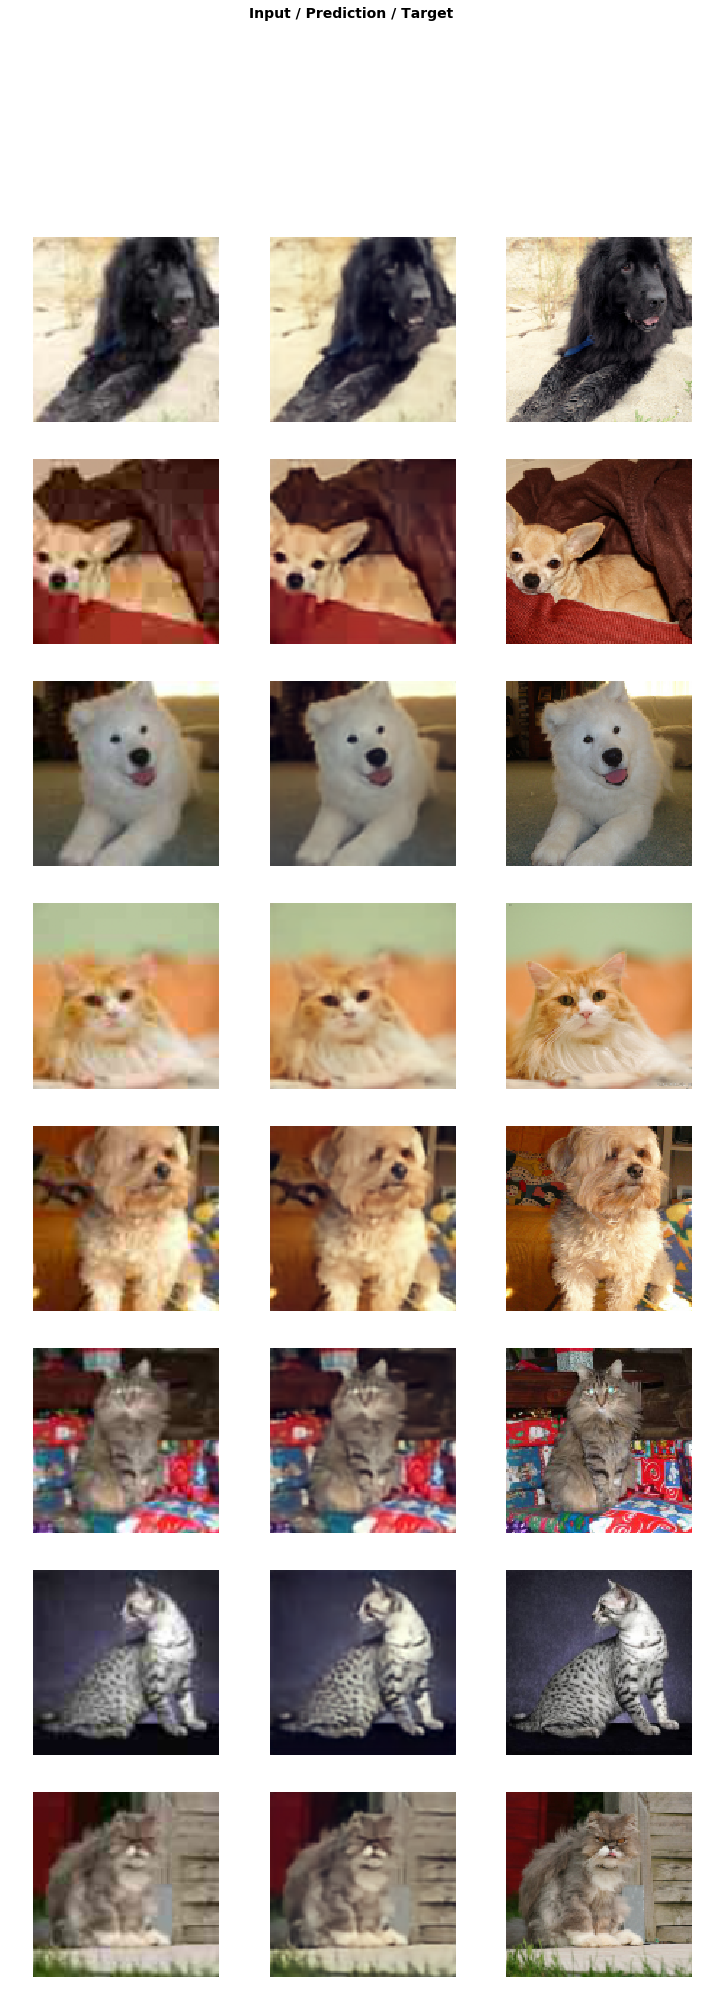

In [21]:
learn_gen.show_results(rows=8)

In [22]:
learn_gen.save('gen-pre')

## GAN

Now we'll combine those pretrained model in a GAN.

In [18]:
from fastai.vision.gan import *

Those are the losses from before.

In [26]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())
loss_gen    = MSELossFlat()

In [27]:
learn_crit = Learner(data_crit, critic(), loss_func=loss_critic).load('critic-pre')

In [28]:
learn_gen = unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Spectral,
                         self_attention=True, loss_func=loss_gen).load('gen-pre')

To define a GAN Learner, we just have to specify the learner objects foor the generator and the critic. The switcher is a callback that decides when to switch from discriminator to generator and vice versa. Here we do as many iterations of the discriminator as needed to get its loss back < 0.5 then one iteration of the generator.

The loss of the critic is given by `learn_crit.loss_func`. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predicitions (target 0). 

The loss of the generator is weighted sum (weights in `weights_gen`) of `learn_crit.loss_func` on the batch of fake (passed throught the critic to become predictions) with a target of 1, and the `learn_gen.loss_func` applied to the output (batch of fake) and the target (corresponding batch of superres images).

In [29]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.5)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0,0.99)), wd=0)

In [30]:
#Adaptive schedule 0.5, 50 epochs, lr=1e-4 from size 256 dense block
learn.fit(50,1e-4)

In [32]:
learn.fit(20,1e-5)

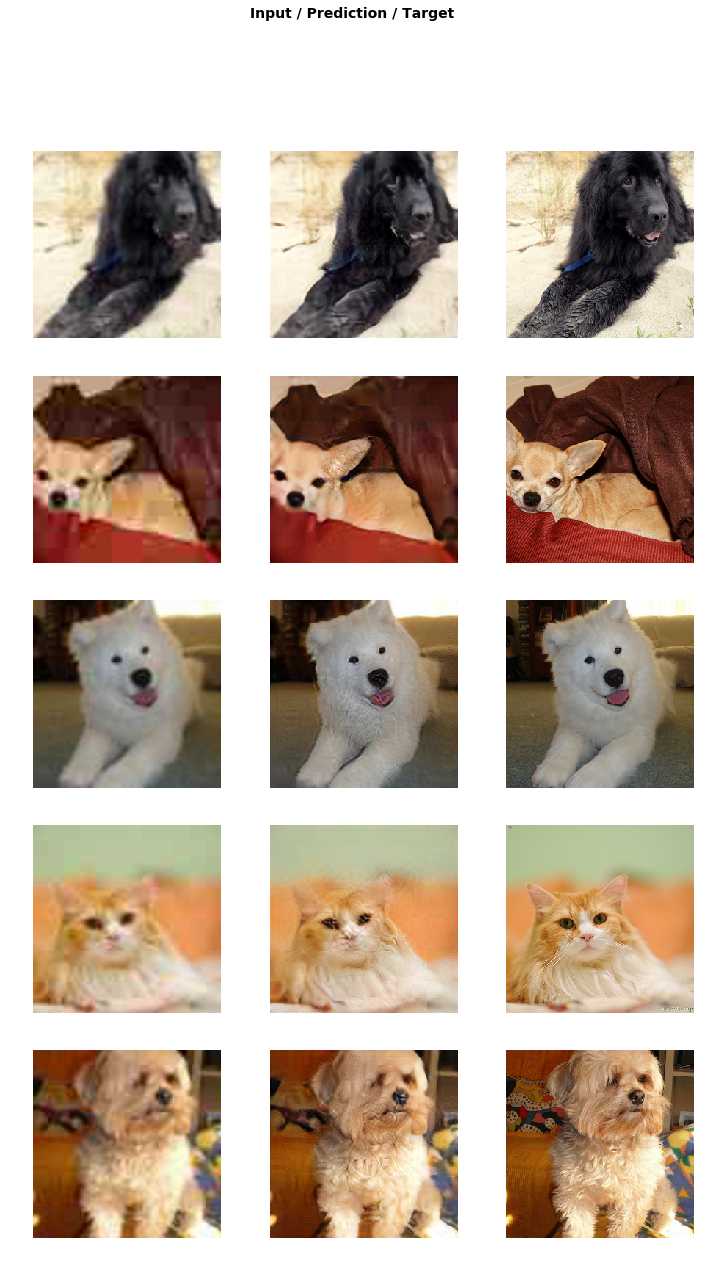

In [33]:
learn.show_results()

In [26]:
#Adaptive schedule 0.5, 60 epochs, lr=1e-4 from size 256
learn.fit(80,5e-5)

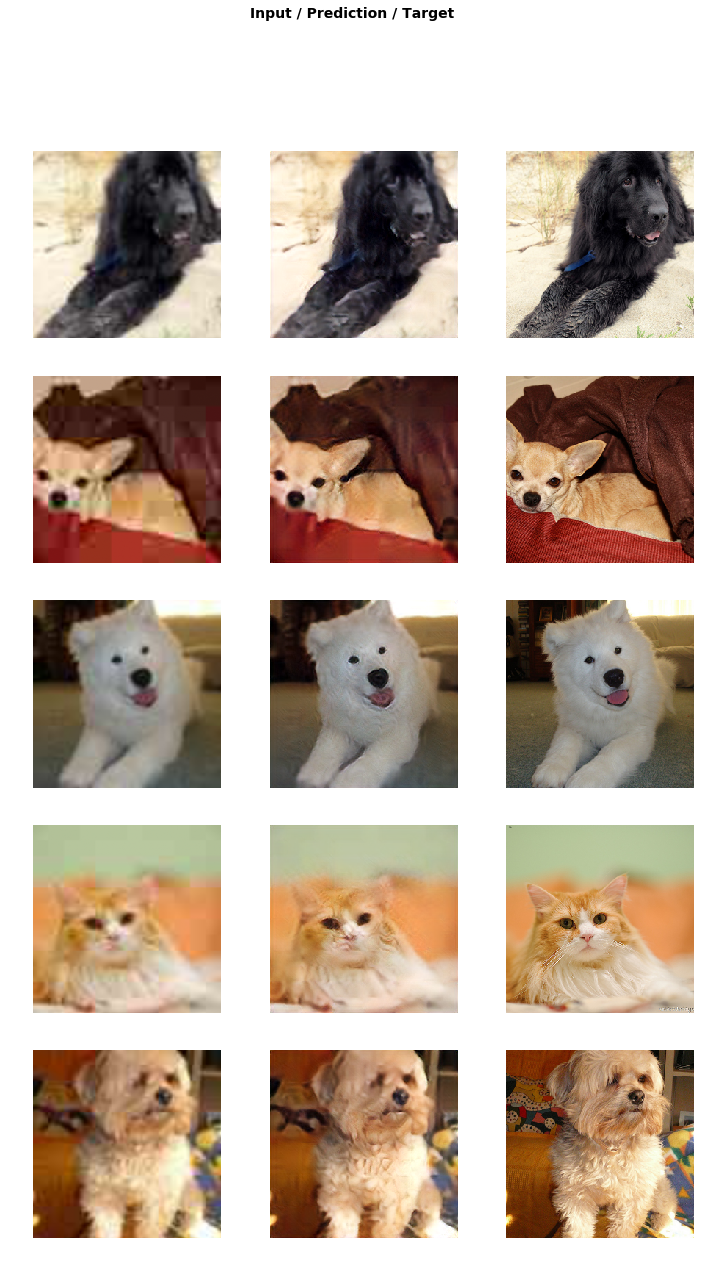

In [25]:
learn.show_results()

Finetuning at a lower learning rate.

In [28]:
learn.fit(20,1e-5)

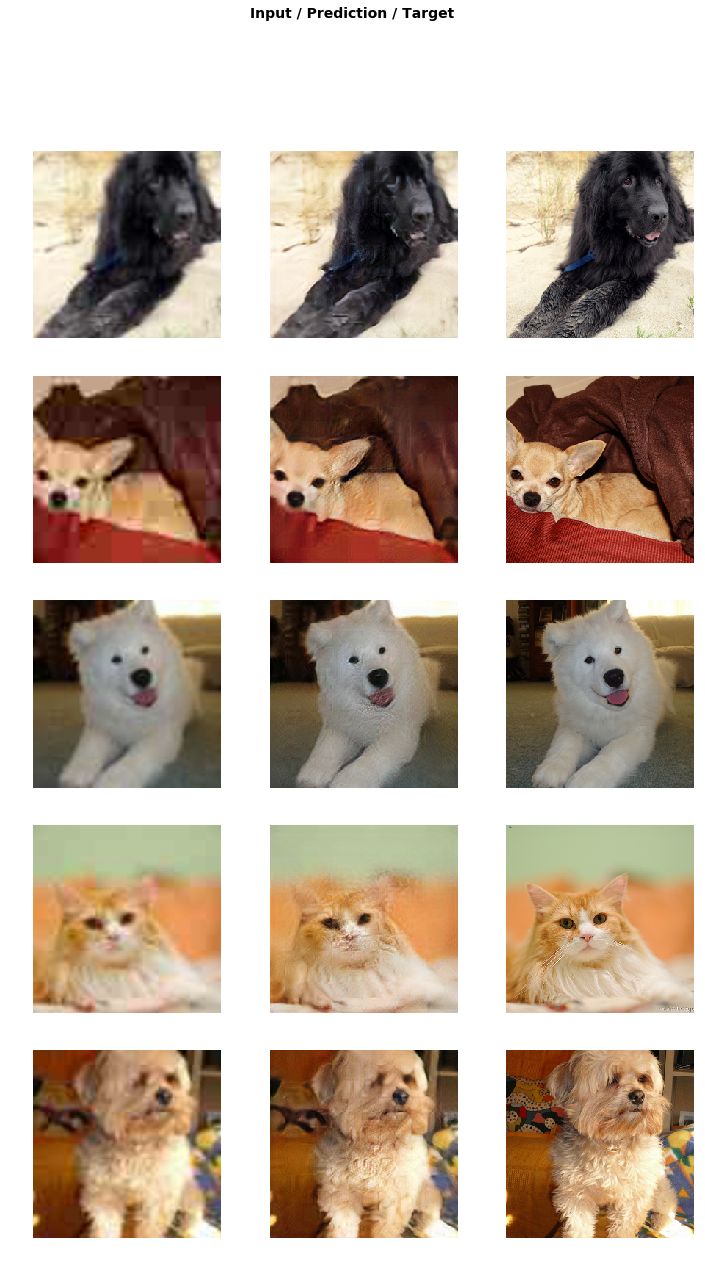

In [29]:
#Adaptive schedule 0.5, 60 epochs, lr=1e-4 + fine-tuned 20 epochs 1e-5
learn.show_results()

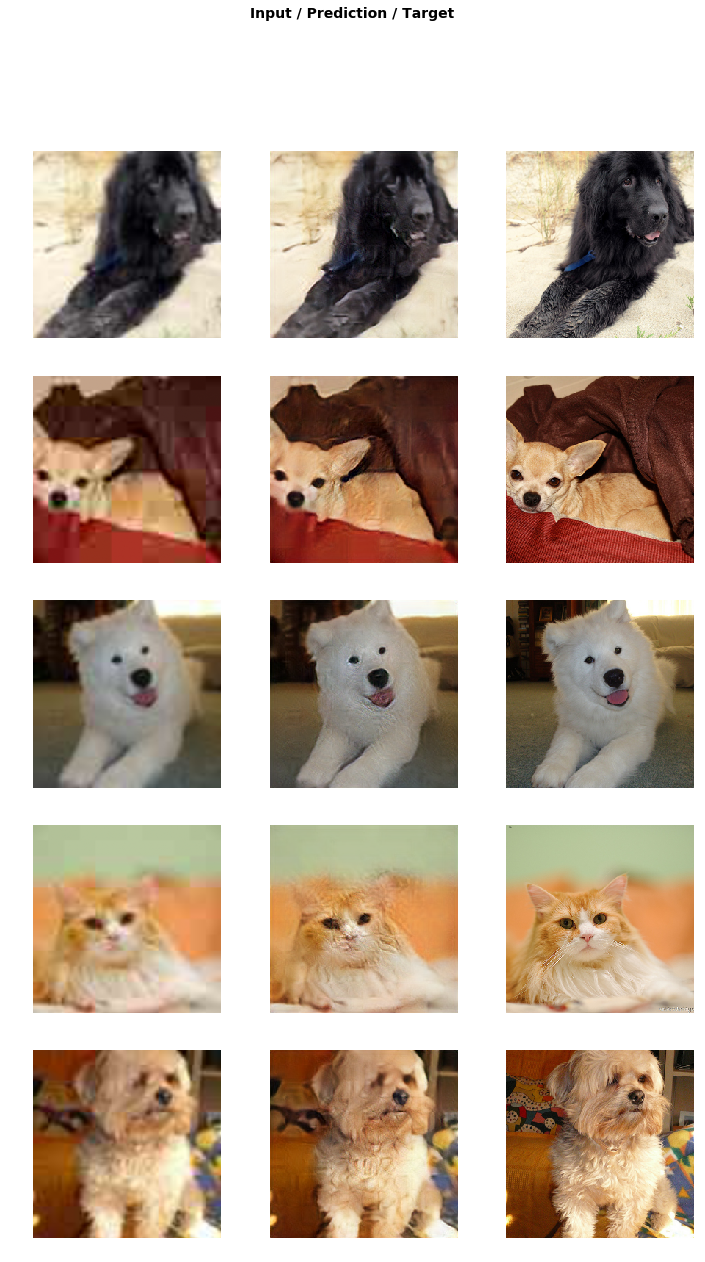

In [27]:
#Adaptive schedule 0.5, 60 epochs, lr=1e-4
learn.show_results()

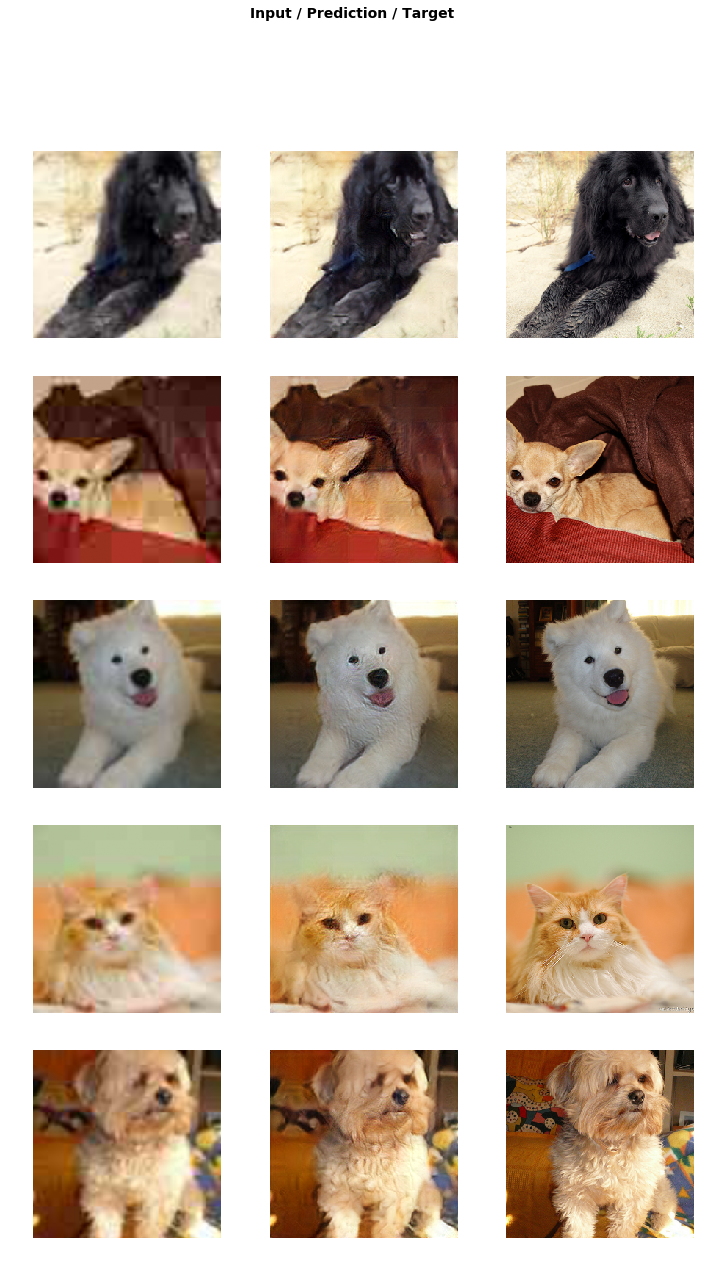

In [23]:
#Fixed schedule 1 to 5, 60 epochs, lr=1e-4
learn.show_results()

In [26]:
learn.save('size256f')
torch.save(learn.gan_trainer.opt_critic.state_dict(), path/'models'/'opt_crit_256f.pth')
torch.save(learn.gan_trainer.opt_gen.state_dict(), path/'models'/'opt_gen_256f.pth')

In [ ]:
learn.save('size256')
torch.save(learn.gan_trainer.opt_critic.state_dict(), path/'models'/'opt_crit_256.pth')
torch.save(learn.gan_trainer.opt_gen.state_dict(), path/'models'/'opt_gen_256.pth')

## fin